# RANSynCoders Example 

#### Packages

In [1]:
from eval_methods import bf_search, blind_bf_search, calc_twseq, calc_seq
from main import RANSynCoders
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

## Data Setup
The attached PSM dataset is used in this example

#### Training data

In [2]:
dirpath = os.getcwd()
x_train = pd.read_csv(os.path.join(dirpath, 'data', 'train.csv'), index_col=[0])
x_train.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24
timestamp_(min),,,,,,,,,,,,,,,,,,,,,
0.0,0.732689,0.761748,0.606848,0.488746,0.424310,0.403609,0.519318,0.398792,0.451453,0.447077,...,0.318797,0.451856,0.571500,0.469717,0.609883,0.008432,0.0,0.481838,0.006536,0.138249
1.0,0.732799,0.761855,0.607133,0.488781,0.432008,0.410256,0.511364,0.402568,0.455657,0.449474,...,0.321463,0.456123,0.562226,0.466533,0.629812,0.008432,0.0,0.477218,0.006536,0.115207
2.0,0.732938,0.761594,0.606895,0.488791,0.418858,0.407724,0.488636,0.396526,0.456104,0.451282,...,0.347219,0.456692,0.572002,0.487845,0.643598,0.006745,0.0,0.492623,0.008715,0.092166
3.0,0.732893,0.761656,0.606478,0.488802,0.417896,0.404242,0.500000,0.405589,0.460020,0.456628,...,0.361904,0.460532,0.563354,0.479512,0.644690,0.008432,0.0,0.457064,0.008715,0.142857
4.0,0.732788,0.761573,0.606777,0.488800,0.421103,0.407407,0.511364,0.399547,0.458507,0.454611,...,0.359767,0.458825,0.563354,0.448298,0.629948,0.006745,0.0,0.472223,0.006536,0.170507


Synchrony estimation requires consistently sampled training dataset, the steps below adds any missing rows in the dataset

In [3]:
#x_train = pd.concat(
#    [pd.DataFrame(index = np.arange(x.index[0], x_train.index[-1]+1)), x_train], axis=1
#)  # uncomment this to fix index for missing rows (not needed for PSM dataset)
x_train.fillna(0, inplace=True)  # imputes missing values

#### Test data

In [4]:
x_test = pd.read_csv(os.path.join(dirpath, 'data', 'test.csv'), index_col=[0])
x_test.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24
timestamp_(min),,,,,,,,,,,,,,,,,,,,,
132480.0,0.775374,0.909185,0.606704,0.660626,0.449968,0.426717,0.471591,0.434668,0.479511,0.478078,...,0.400617,0.480444,0.588670,0.404036,0.638957,0.020236,0.042705,0.173375,0.008715,0.105991
132481.0,0.775423,0.909142,0.607796,0.660655,0.487813,0.442545,0.505682,0.448640,0.499451,0.494367,...,0.396902,0.500213,0.587041,0.421605,0.637865,0.018550,0.042705,0.191826,0.010893,0.110599
132482.0,0.775458,0.909004,0.607988,0.660623,0.469532,0.433682,0.477273,0.450906,0.487223,0.484878,...,0.389270,0.487982,0.582404,0.407393,0.636091,0.018550,0.039146,0.188361,0.010893,0.115207
132483.0,0.775513,0.909200,0.607218,0.660640,0.459910,0.435581,0.482955,0.454683,0.490431,0.488316,...,0.403780,0.491253,0.584660,0.407141,0.638138,0.020236,0.042705,0.186975,0.013072,0.110599
132484.0,0.775587,0.909318,0.606654,0.660643,0.462155,0.436214,0.477273,0.449396,0.494671,0.487094,...,0.403636,0.495947,0.581527,0.402761,0.632678,0.021922,0.042705,0.156325,0.008715,0.110599


Prediction data do not require to have consistent sampling, since this method does not use time windows. However, the sample's timestamp is required as part of the model's and must share the same reference frame as that of the training dataset (e.g. epoch-time.

#### Labels

In [5]:
y_test = pd.read_csv(os.path.join(dirpath, 'data', 'test_label.csv'), index_col=[0])
y_test.head()

,label
timestamp_(min),
132480.0,0
132481.0,0
132482.0,0
132483.0,0
132484.0,0


### Preprocessing

#### Extract epochtime (T) Matrix
The sampling time is consistent across all features for the PSM dataset, thus a single index can be used to create the T matrix

In [6]:
t_train = np.tile(x_train.index.values.reshape(-1,1), (1, x_train.shape[1])) 
t_test = np.tile(x_test.index.values.reshape(-1,1), (1, x_train.shape[1]))

#### Normalization

In [7]:
xscaler = MinMaxScaler()
x_train_scaled = xscaler.fit_transform(x_train.values)
x_test_scaled = xscaler.transform(x_test.values)

## Model Setup

#### Hyperparameters
The logic below for hyperparameter setting is not based on any science. Users are invited to conduct hyperpameter search and evaluation. In General, the encoder-decoder ensembling method increases robustness across a wide range of non-extreme parameter values

In [8]:
N = 5 * round((x_train.shape[1] / 3) / 5)  # 10 for both bootstrap sample size and number of estimators
encoder_layers = 1  # number of hidden layers for each encoder
decoder_layers = 2  # number of hidden layers for each decoder
z = int((N / 2) - 1)  # size of latent space
activation = 'relu'
output_activation = 'sigmoid'
S = 5  # Number of frequency components to fit to input signals
delta = 0.05
batch_size = 180
freq_warmup = 5  # pre-training epochs
sin_warmup = 5  # synchronization pre-training
epochs = 10

#### Initialize & compile

In [9]:
model = RANSynCoders(
    n_estimators=N, 
    max_features=N, 
    encoding_depth=encoder_layers, 
    latent_dim=z, 
    decoding_depth=decoder_layers, 
    activation=activation,
    output_activation=output_activation,
    delta=delta,
    synchronize=True,
    max_freqs=S,
)

In [10]:
model.fit(x_train_scaled, t_train, epochs=epochs, batch_size=batch_size, freq_warmup=freq_warmup, sin_warmup=sin_warmup)


Start of frequency pre-train epoch 0
pre-reconstruction_loss: 0.03980063
Start of frequency pre-train epoch 1
pre-reconstruction_loss: 0.024229577
Start of frequency pre-train epoch 2
pre-reconstruction_loss: 0.021935325
Start of frequency pre-train epoch 3
pre-reconstruction_loss: 0.01657161
Start of frequency pre-train epoch 4

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

found common oscillations at period(s) = [1440.0108695652173, 480.0036231884058, 720.0054347826086, 360.0027173913043, 60.000452898550726]

Start of sine representation pre-tra

#### Saving

In [11]:
model.save('example_model.z')

<AxesSubplot:>

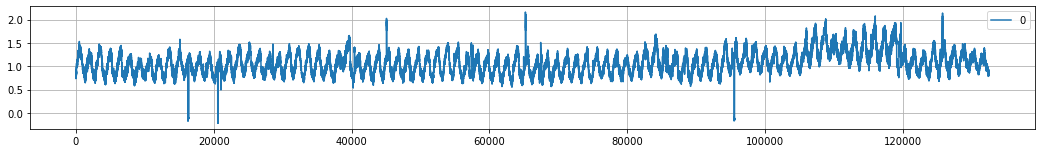

In [14]:
# visualize the common oscillations from the latent space output
pd.DataFrame(model.freqcoder.layers[1].latent(x_train_scaled).numpy()).plot(figsize=(18,2.25), grid=True)

## Results

#### Model outputs

In [16]:
sins, synched, upper, lower = model.predict(x_test_scaled, t_test, batch_size=batch_size*10)

#### Visualize synchronization impact
Synchronization results in increasing multicolinearity, thus reducing the amount of information and the size dimensionality of the latent space

Text(0.5, 1.0, 'After Synchronization')

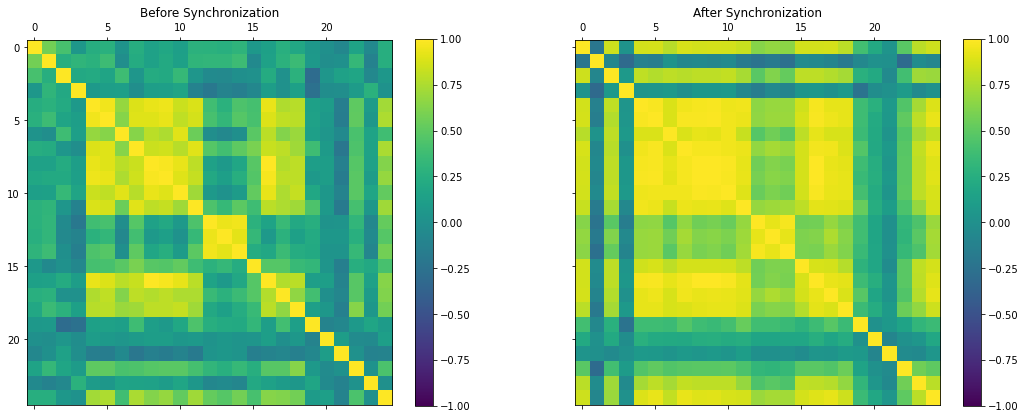

In [17]:
# Get transformed signal
x_test_synched = pd.DataFrame(synched, index=x_test.index, columns=x_test.columns)

# Compare correlation matriices
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(18,6.75))
corr0=ax1.matshow(pd.DataFrame(x_test_scaled).corr(), vmin=-1, vmax=1)
fig.colorbar(corr0, ax=ax1)
ax1.set_title('Before Synchronization')
corr1=ax2.matshow(x_test_synched.corr(), vmin=-1, vmax=1)
fig.colorbar(corr1, ax=ax2)
ax2.set_title('After Synchronization')

### Accuracy evaluation

In [19]:
synched_tiles = np.tile(synched.reshape(synched.shape[0], 1, synched.shape[1]), (1, N, 1))
result = np.where((synched_tiles < lower) | (synched_tiles > upper), 1, 0)
inference = np.mean(np.mean(result, axis=1), axis=1)

#### $F1_{best}$

In [21]:
t, th = bf_search(inference.reshape(-1,1), y_test.values, start=0., end=0.9, step_num=int((0.9-0.)/0.0001), display_freq=5000)

search range:  0.0 0.9
cur thr:  0.0001 [0.43486683670741033, 0.27784932018850933, 0.9999999995898445, 0.9985502677279309, 24381, 92, 63368, 0, 0.0] [0.43486683670741033, 0.27784932018850933, 0.9999999995898445, 0.9985502677279309, 24381, 92, 63368, 0, 0.0] 0.0001 (-1.0, -1.0, -1.0) 0.0
cur thr:  0.5000999999999612 [0.8013699329548061, 0.9980432915506645, 0.6694557234447087, 0.0005042546485180815, 16322, 63428, 32, 8059, 178.64158113156336] [0.9407402258969699, 0.9917708565620501, 0.8947130958965124, 0.0028521903556803984, 21814, 63279, 181, 2567, 154.08628658136269] 0.4440999999999674 [0.9407402258969699, 0.9917708565620501, 0.8947130958965124, 0.0028521903556803984, 21814, 63279, 181, 2567, 154.08628658136269] 0.4440999999999674
[0.9407402258969699, 0.9917708565620501, 0.8947130958965124, 0.0028521903556803984, 21814, 63279, 181, 2567, 154.08628658136269] 0.4440999999999674 [0.9407402258969699, 0.9917708565620501, 0.8947130958965124, 0.0028521903556803984, 21814, 63279, 181, 2567, 15

F1 = 0.9407402258969699  
Precision = 0.9917708565620501  
Recall = 0.8947130958965124  

#### ${F1^*}_{blind}$

In [34]:
split = int(inference.shape[0]/2)
inference_test, labels_test = inference[split:], y_test.values[split:]
inference_val, labels_val = inference[:split], y_test.values[:split]
t, th = blind_bf_search(
    inference_test.reshape(-1,1), 
    labels_test, 
    (inference_val.reshape(-1,1), labels_val), 
    start=0., 
    end=0.9, 
    step_num=int((0.9-0.)/0.0001), 
    display_freq=5000, 
    tw=15  # rolling time window
)

search range:  0.0 0.9
cur in-sample thr:  0.0001 (0.4153563606682816, 0.2621160400610374, 0.9999999869791669, 0.999999995374653, 768.0, 0.0, 2162.0, 0.0) (0.4153563606682816, 0.2621160400610374, 0.9999999869791669, 0.999999995374653, 768.0, 0.0, 2162.0, 0.0) 0.0001
cur in-sample thr:  0.5000999999999612 (0.9228561669055504, 0.9999999848024319, 0.8567708221774633, 0.0, 658.0, 2162.0, 0.0, 110.0) (0.9366341223162772, 0.9941520322492393, 0.885416655137804, 0.0018501387518494968, 680.0, 2158.0, 4.0, 88.0) 0.4240999999999696

Out-of-sample score:
(0.727851385106576, 0.8915094199448205, 0.6149674553691166, 0.03434544532431336, 567.0, 1940.0, 69.0, 355.0) 0.4240999999999696


F1 = 0.727851385106576  
Precision = 0.8915094199448205  
Recall = 0.6149674553691166  

#### $F1_{init}$

In [38]:
calc_twseq(inference.reshape(-1,1), y_test.values, 0, 0.5, 15)

(0.7086926983984027,
 0.9883474471573364,
 0.5523978652907172,
 0.0026372572461346028,
 933.0,
 4160.0,
 11.0,
 756.0)

F1 = 0.7086926983984027   
Precision = 0.9883474471573364  
Recall = 0.5523978652907172

#### ${F1^*}_{init}$

In [40]:
calc_seq(inference.reshape(-1,1), y_test.values, 0.5, pred=inference.reshape(-1,1)>0.5)

(0.8013699329548061,
 0.9980432915506645,
 0.6694557234447087,
 0.0005042546485180815,
 16322,
 63428,
 32,
 8059)

F1 = 0.8013699329548061  
Precision = 0.9980432915506645    
Recall = 0.66945572344470872  